##掛載雲端硬碟


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##更改檔案所在路徑

In [ ]:
# Change to your own folder !!!
%cd /content/drive/MyDrive/Colab Notebooks/AI_lab4

/content/drive/MyDrive/Colab Notebooks/AI_lab4


## Import library

In [ ]:
from __future__ import print_function
import os
import argparse

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

from models import vgg

## 設定超參數(LAMBDA=0)

In [ ]:
SPARSITY_REGULARIZATION = True
#### 設定λ(balance factor) ####
################################################
#          請填空          #
################################################
LAMBDA = 0 ##0 1e-5

SEED = 1
TRAIN_BATCH_SIZE = 100
TEST_BATCH_SIZE = 1000
EPOCHS = 60
LEARNING_RATE = 0.1
MOMENTUM = 0.9
WEIGHT_DECAY = 1e-4
LOG_INTERVAL = 100
CUDA = True

RESUME = False
START_EPOCH = 0

WEIGHT_PATH = '/content/drive/MyDrive/Colab Notebooks/model_best.pth'


In [ ]:
if(torch.cuda.is_available()):
    CUDA = True
    kwargs = {'num_workers': 1, 'pin_memory': True}
    torch.cuda.manual_seed(SEED)
else:
    CUDA = False
    kwargs = {}


##下載資料集


這裡將訓練集做Augmentation(Pad, RandCrop, Random)，測試集不用做Augmentation

In [ ]:
#### 資料集 ####
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.Pad(4),
                       transforms.RandomCrop(32),
                       transforms.RandomHorizontalFlip(),
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])),
    batch_size=TRAIN_BATCH_SIZE, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])),
    batch_size=TEST_BATCH_SIZE, shuffle=True, **kwargs)

Files already downloaded and verified


## 定義模型與載入訓練好的權重

In [ ]:
model = vgg()
if CUDA:
    model.cuda()

##設定Optimizer，這裡使用Stocastic Gradient Descent

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

##使用論文中稀疏化的方式更新參數(填空)

In [ ]:
def updateBN():
  for m in model.modules():
      if isinstance(m, nn.BatchNorm2d):
          #### 完成Sparsity Regularization ####
          ################################################
          #          請填空          #
          m.weight.grad.data.add_(LAMBDA*torch.sign(m.weight.data))
          ################################################







## 載入預先定義好的模型與參數

In [ ]:
if(RESUME):
  checkpoint = torch.load(WEIGHT_PATH)
  model.load_state_dict(checkpoint['state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer'])
  START_EPOCH = checkpoint['epoch']
  best_prec1 = checkpoint['best_prec1']
  print(f'RESUME MODEL @EPOCH={START_EPOCH}, BEST_PREC1={best_prec1}')

RESUME MODEL @EPOCH=50, BEST_PREC1=0.9271000027656555


## 定義訓練跟測試函數

In [ ]:
#### 訓練函數 #####
train_accuracies = [] #儲存train acc
# 注意: 需自行撰寫儲存每個epoch之train acc的code，以便後續繪製train acc結果圖!
def train(epoch):
    model.train()
    correct = 0
    total = 0


    for batch_idx, (data, target) in enumerate(train_loader):
        if CUDA:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()

        if SPARSITY_REGULARIZATION:
            updateBN()
        optimizer.step()

        ##計算正確預測數
        _, predicted = output.max(1)
        correct += predicted.eq(target).sum().item()
        total += target.size(0)

        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.1f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))
    train_accuracy = 100. * correct / total
    train_accuracies.append(train_accuracy)
    print('Training Accuracy for Epoch {}: {:.2f}%'.format(epoch, train_accuracy))

#### 測試函數 ####
def test():
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
      for data, target in test_loader:
          if CUDA:
              data, target = data.cuda(), target.cuda()
          data, target = Variable(data), Variable(target)
          output = model(data)
          test_loss += F.cross_entropy(output, target, reduction='sum').data.item()
          pred = output.data.max(1, keepdim=True)[1]
          correct += pred.eq(target.data.view_as(pred)).cpu().sum()

      test_loss /= len(test_loader.dataset)
      print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
          test_loss, correct, len(test_loader.dataset),
          100. * correct / len(test_loader.dataset)))
      return correct / float(len(test_loader.dataset))

best_prec1 = 0.
for epoch in range(START_EPOCH, EPOCHS):
    # Learning Rate在0.5EPOCHS與0.75EPOCHS調整為原本1/10
    if epoch in [EPOCHS*0.5, EPOCHS*0.75]:
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.1
    train(epoch)
    prec1 = test()

    # 儲存模型權重，方便做後續剪枝,後續訓練
    if(prec1 > best_prec1):
        torch.save({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'best_prec1': best_prec1,
            'optimizer': optimizer.state_dict(),
        }, WEIGHT_PATH)

    best_prec1 = max(prec1, best_prec1)


##繪製Sparsity-Training結果圖

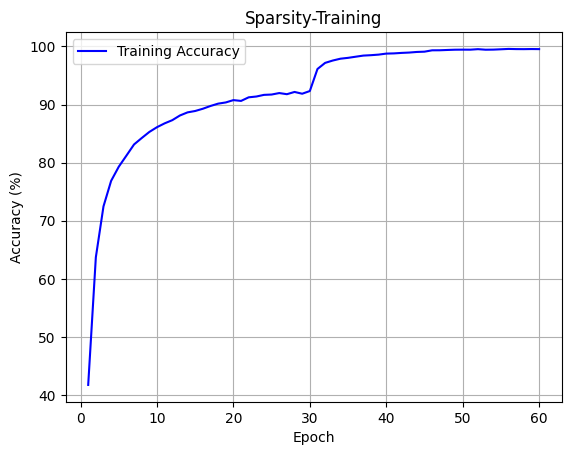

In [ ]:
#繪製 Sparsity-Training 結果圖
import matplotlib.pyplot as plt
epochs = range(1, EPOCHS + 1)
plt.plot(epochs, train_accuracies , 'b', label='Training Accuracy')
plt.title('Sparsity-Training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

## 繪製scaling factor 分布圖

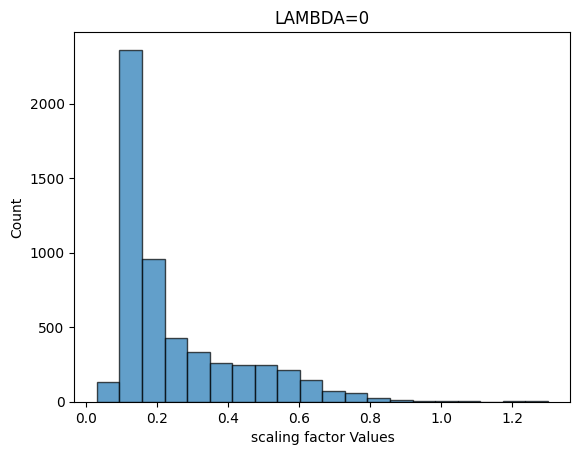

In [ ]:
#繪製 scaling factor 分布圖
import numpy as np

gamma_values = []


for layer in model.modules():
    if isinstance(layer, torch.nn.BatchNorm2d):
        gamma = layer.weight.data.cpu().numpy()
        gamma_values.extend(gamma)

import matplotlib.pyplot as plt

plt.hist(gamma_values, bins=20, edgecolor='k', alpha=0.7)
plt.title("LAMBDA=0")
plt.xlabel("scaling factor Values")
plt.ylabel("Count")
plt.show()

## 設定超參數(LAMBDA=1e-5)

In [ ]:
SPARSITY_REGULARIZATION = True
#### 設定λ(balance factor) ####
################################################
#          請填空          #
################################################
LAMBDA = 1e-5

SEED = 1
TRAIN_BATCH_SIZE = 100
TEST_BATCH_SIZE = 1000
EPOCHS = 60
LEARNING_RATE = 0.1
MOMENTUM = 0.9
WEIGHT_DECAY = 1e-4
LOG_INTERVAL = 100
CUDA = True

RESUME = False
START_EPOCH = 0

WEIGHT_PATH = '/content/drive/MyDrive/Colab Notebooks/model_best_2.pth'


In [ ]:
if(torch.cuda.is_available()):
    CUDA = True
    kwargs = {'num_workers': 1, 'pin_memory': True}
    torch.cuda.manual_seed(SEED)
else:
    CUDA = False
    kwargs = {}


In [ ]:
#### 資料集 ####
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.Pad(4),
                       transforms.RandomCrop(32),
                       transforms.RandomHorizontalFlip(),
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])),
    batch_size=TRAIN_BATCH_SIZE, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])),
    batch_size=TEST_BATCH_SIZE, shuffle=True, **kwargs)

Files already downloaded and verified


In [ ]:
model = vgg()
if CUDA:
    model.cuda()

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

In [ ]:
def updateBN():
  for m in model.modules():
      if isinstance(m, nn.BatchNorm2d):
          #### 完成Sparsity Regularization ####
          ################################################
          #          請填空          #
          m.weight.grad.data.add_(LAMBDA*torch.sign(m.weight.data))
          ################################################

In [ ]:
if(RESUME):
  checkpoint = torch.load(WEIGHT_PATH)
  model.load_state_dict(checkpoint['state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer'])
  START_EPOCH = checkpoint['epoch']
  best_prec1 = checkpoint['best_prec1']
  print(f'RESUME MODEL @EPOCH={START_EPOCH}, BEST_PREC1={best_prec1}')

In [ ]:
#### 訓練函數 #####
train_accuracies = [] #儲存train acc
# 注意: 需自行撰寫儲存每個epoch之train acc的code，以便後續繪製train acc結果圖!
def train(epoch):
    model.train()
    correct = 0
    total = 0


    for batch_idx, (data, target) in enumerate(train_loader):
        if CUDA:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()

        if SPARSITY_REGULARIZATION:
            updateBN()
        optimizer.step()

        ##計算正確預測數
        _, predicted = output.max(1)
        correct += predicted.eq(target).sum().item()
        total += target.size(0)

        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.1f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))
    train_accuracy = 100. * correct / total
    train_accuracies.append(train_accuracy)
    print('Training Accuracy for Epoch {}: {:.2f}%'.format(epoch, train_accuracy))

#### 測試函數 ####
def test():
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
      for data, target in test_loader:
          if CUDA:
              data, target = data.cuda(), target.cuda()
          data, target = Variable(data), Variable(target)
          output = model(data)
          test_loss += F.cross_entropy(output, target, reduction='sum').data.item()
          pred = output.data.max(1, keepdim=True)[1]
          correct += pred.eq(target.data.view_as(pred)).cpu().sum()

      test_loss /= len(test_loader.dataset)
      print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
          test_loss, correct, len(test_loader.dataset),
          100. * correct / len(test_loader.dataset)))
      return correct / float(len(test_loader.dataset))

best_prec1 = 0.
for epoch in range(START_EPOCH, EPOCHS):
    # Learning Rate在0.5EPOCHS與0.75EPOCHS調整為原本1/10
    if epoch in [EPOCHS*0.5, EPOCHS*0.75]:
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.1
    train(epoch)
    prec1 = test()

    # 儲存模型權重，方便做後續剪枝,後續訓練
    if(prec1 > best_prec1):
        torch.save({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'best_prec1': best_prec1,
            'optimizer': optimizer.state_dict(),
        }, WEIGHT_PATH)

    best_prec1 = max(prec1, best_prec1)


Train Epoch: 0 [0/50000 (0.0%)]	Loss: 2.308759
Train Epoch: 0 [10000/50000 (20.0%)]	Loss: 1.585389
Train Epoch: 0 [20000/50000 (40.0%)]	Loss: 1.417026
Train Epoch: 0 [30000/50000 (60.0%)]	Loss: 1.213608
Train Epoch: 0 [40000/50000 (80.0%)]	Loss: 1.321739
Training Accuracy for Epoch 0: 42.52%

Test set: Average loss: 1.2616, Accuracy: 5414/10000 (54.1%)

Train Epoch: 1 [0/50000 (0.0%)]	Loss: 0.982155
Train Epoch: 1 [10000/50000 (20.0%)]	Loss: 1.073590
Train Epoch: 1 [20000/50000 (40.0%)]	Loss: 1.275843
Train Epoch: 1 [30000/50000 (60.0%)]	Loss: 1.006308
Train Epoch: 1 [40000/50000 (80.0%)]	Loss: 0.948064
Training Accuracy for Epoch 1: 63.87%

Test set: Average loss: 0.9354, Accuracy: 6755/10000 (67.6%)

Train Epoch: 2 [0/50000 (0.0%)]	Loss: 0.832757
Train Epoch: 2 [10000/50000 (20.0%)]	Loss: 1.005279
Train Epoch: 2 [20000/50000 (40.0%)]	Loss: 0.775863
Train Epoch: 2 [30000/50000 (60.0%)]	Loss: 0.766885
Train Epoch: 2 [40000/50000 (80.0%)]	Loss: 0.962790
Training Accuracy for Epoch 2: 71

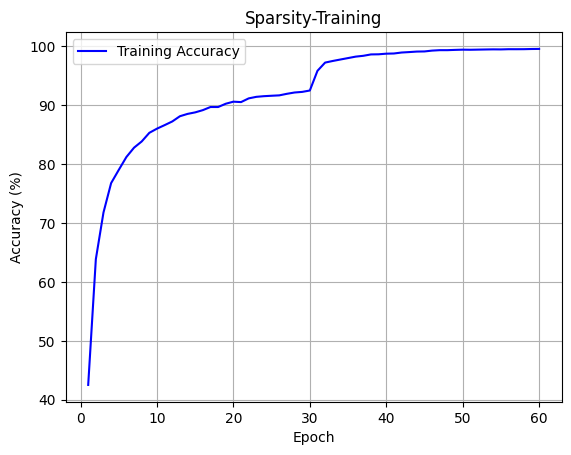

In [ ]:
#繪製 Sparsity-Training 結果圖
import matplotlib.pyplot as plt
epochs = range(1, EPOCHS + 1)
plt.plot(epochs, train_accuracies , 'b', label='Training Accuracy')
plt.title('Sparsity-Training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

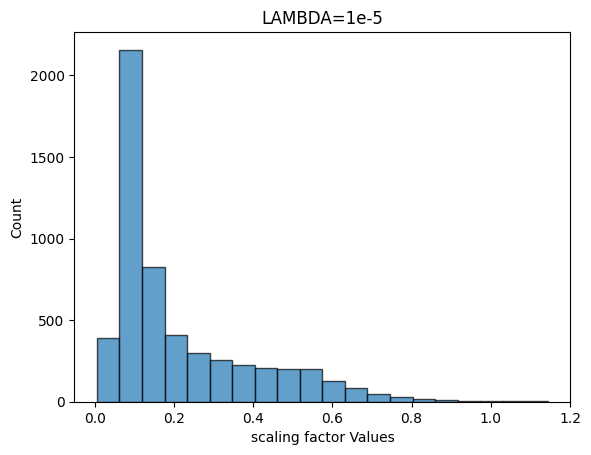

In [ ]:
#繪製 scaling factor 分布圖
import numpy as np

gamma_values = []


for layer in model.modules():
    if isinstance(layer, torch.nn.BatchNorm2d):
        gamma = layer.weight.data.cpu().numpy()
        gamma_values.extend(gamma)

import matplotlib.pyplot as plt

plt.hist(gamma_values, bins=20, edgecolor='k', alpha=0.7)
plt.title("LAMBDA=1e-5")
plt.xlabel("scaling factor Values")
plt.ylabel("Count")
plt.show()

## 設定超參數(LAMBDA=1e-4)

In [ ]:
SPARSITY_REGULARIZATION = True
#### 設定λ(balance factor) ####
################################################
#          請填空          #
################################################
LAMBDA = 1e-4

SEED = 1
TRAIN_BATCH_SIZE = 100
TEST_BATCH_SIZE = 1000
EPOCHS = 60
LEARNING_RATE = 0.1
MOMENTUM = 0.9
WEIGHT_DECAY = 1e-4
LOG_INTERVAL = 100
CUDA = True

RESUME = False
START_EPOCH = 0

WEIGHT_PATH = '/content/drive/MyDrive/Colab Notebooks/model_best.pth'

In [ ]:
if(torch.cuda.is_available()):
    CUDA = True
    kwargs = {'num_workers': 1, 'pin_memory': True}
    torch.cuda.manual_seed(SEED)
else:
    CUDA = False
    kwargs = {}

In [ ]:
#### 資料集 ####
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.Pad(4),
                       transforms.RandomCrop(32),
                       transforms.RandomHorizontalFlip(),
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])),
    batch_size=TRAIN_BATCH_SIZE, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])),
    batch_size=TEST_BATCH_SIZE, shuffle=True, **kwargs)

Files already downloaded and verified


In [ ]:
model = vgg()
if CUDA:
    model.cuda()

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

In [ ]:
def updateBN():
  for m in model.modules():
      if isinstance(m, nn.BatchNorm2d):
          #### 完成Sparsity Regularization ####
          ################################################
          #          請填空          #
          m.weight.grad.data.add_(LAMBDA*torch.sign(m.weight.data))
          ################################################

In [ ]:
if(RESUME):
  checkpoint = torch.load(WEIGHT_PATH)
  model.load_state_dict(checkpoint['state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer'])
  START_EPOCH = checkpoint['epoch']
  best_prec1 = checkpoint['best_prec1']
  print(f'RESUME MODEL @EPOCH={START_EPOCH}, BEST_PREC1={best_prec1}')

In [ ]:
#### 訓練函數 #####
train_accuracies3 = [] #儲存train acc
# 注意: 需自行撰寫儲存每個epoch之train acc的code，以便後續繪製train acc結果圖!
def train(epoch):
    model.train()
    correct = 0
    total = 0


    for batch_idx, (data, target) in enumerate(train_loader):
        if CUDA:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()

        if SPARSITY_REGULARIZATION:
            updateBN()
        optimizer.step()

        ##計算正確預測數
        _, predicted = output.max(1)
        correct += predicted.eq(target).sum().item()
        total += target.size(0)

        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.1f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))
    train_accuracy = 100. * correct / total
    train_accuracies3.append(train_accuracy)
    print('Training Accuracy for Epoch {}: {:.2f}%'.format(epoch, train_accuracy))

#### 測試函數 ####
def test():
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
      for data, target in test_loader:
          if CUDA:
              data, target = data.cuda(), target.cuda()
          data, target = Variable(data), Variable(target)
          output = model(data)
          test_loss += F.cross_entropy(output, target, reduction='sum').data.item()
          pred = output.data.max(1, keepdim=True)[1]
          correct += pred.eq(target.data.view_as(pred)).cpu().sum()

      test_loss /= len(test_loader.dataset)
      print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
          test_loss, correct, len(test_loader.dataset),
          100. * correct / len(test_loader.dataset)))
      return correct / float(len(test_loader.dataset))

best_prec1 = 0.
for epoch in range(START_EPOCH, EPOCHS):
    # Learning Rate在0.5EPOCHS與0.75EPOCHS調整為原本1/10
    if epoch in [EPOCHS*0.5, EPOCHS*0.75]:
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.1
    train(epoch)
    prec1 = test()

    # 儲存模型權重，方便做後續剪枝,後續訓練
    if(prec1 > best_prec1):
        torch.save({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'best_prec1': best_prec1,
            'optimizer': optimizer.state_dict(),
        }, WEIGHT_PATH)

    best_prec1 = max(prec1, best_prec1)


Train Epoch: 0 [0/50000 (0.0%)]	Loss: 1.809155
Train Epoch: 0 [10000/50000 (20.0%)]	Loss: 1.457657
Train Epoch: 0 [20000/50000 (40.0%)]	Loss: 1.244364
Train Epoch: 0 [30000/50000 (60.0%)]	Loss: 1.151301
Train Epoch: 0 [40000/50000 (80.0%)]	Loss: 0.954640
Training Accuracy for Epoch 0: 51.49%

Test set: Average loss: 1.1670, Accuracy: 5960/10000 (59.6%)

Train Epoch: 1 [0/50000 (0.0%)]	Loss: 0.917473
Train Epoch: 1 [10000/50000 (20.0%)]	Loss: 1.046664
Train Epoch: 1 [20000/50000 (40.0%)]	Loss: 1.004256
Train Epoch: 1 [30000/50000 (60.0%)]	Loss: 0.959145
Train Epoch: 1 [40000/50000 (80.0%)]	Loss: 0.961047
Training Accuracy for Epoch 1: 67.23%

Test set: Average loss: 1.1881, Accuracy: 6135/10000 (61.3%)

Train Epoch: 2 [0/50000 (0.0%)]	Loss: 0.739172
Train Epoch: 2 [10000/50000 (20.0%)]	Loss: 0.628132
Train Epoch: 2 [20000/50000 (40.0%)]	Loss: 0.801902
Train Epoch: 2 [30000/50000 (60.0%)]	Loss: 0.510330
Train Epoch: 2 [40000/50000 (80.0%)]	Loss: 0.783994
Training Accuracy for Epoch 2: 73

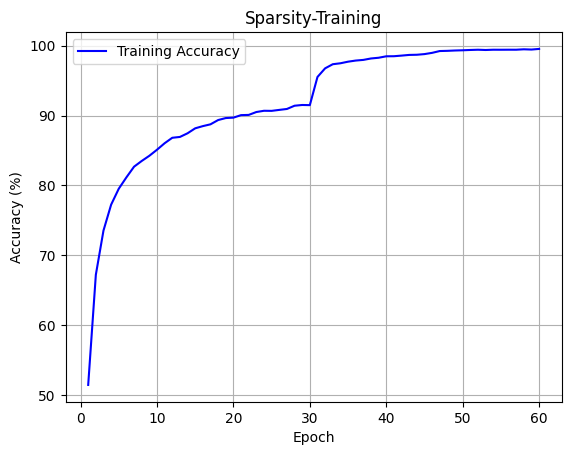

In [ ]:
#繪製 Sparsity-Training 結果圖
import matplotlib.pyplot as plt
epochs = range(1, EPOCHS + 1)
plt.plot(epochs, train_accuracies3 , 'b', label='Training Accuracy')
plt.title('Sparsity-Training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

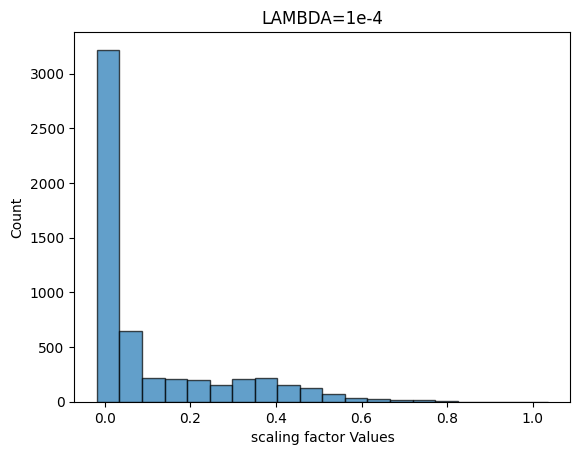

In [ ]:
#繪製 scaling factor 分布圖
import numpy as np

gamma_values = []


for layer in model.modules():
    if isinstance(layer, torch.nn.BatchNorm2d):
        gamma = layer.weight.data.cpu().numpy()
        gamma_values.extend(gamma)

import matplotlib.pyplot as plt

plt.hist(gamma_values, bins=20, edgecolor='k', alpha=0.7)
plt.title("LAMBDA=1e-4")
plt.xlabel("scaling factor Values")
plt.ylabel("Count")
plt.show()